In [43]:
file_path = "/home/ihsannh17/Downloads/RMP/github-repos/etc/2023-12-(04-14)_Label.csv"

In [46]:
#WaveNet
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from nvidia_waveglow2 import WaveGlow

# Load the data
# Update the file path as needed
file_path = "~/x.csv"
data = pd.read_csv(file_path)

# Sort the data by 'Code', 'Name', and 'Time (WIB)'
data = data.sort_values(by=['Code', 'Name', 'Time (WIB)'])

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].copy()
labels = data['Code']

# Handle missing values (replace NaN with mean for simplicity)
features = features.fillna(features.mean())

# Train-test split (80-20 split)
train_size = int(len(features) * 0.8)
train, test = features[:train_size], features[train_size:]

# Normalize features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Convert data to sequences for WaveNet
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append((seq, label))
    return np.array(sequences)

sequence_length = 10  # Adjust based on your preference
train_sequences = create_sequences(train_scaled, sequence_length)
test_sequences = create_sequences(test_scaled, sequence_length)

# Prepare data for training
X_train, y_train = train_sequences[:, :-1], train_sequences[:, -1]
X_test, y_test = test_sequences[:, :-1], test_sequences[:, -1]

# Build and train the WaveNet model
model = WaveGlow(input_shape=(sequence_length - 1, len(features.columns)))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict on test data
y_pred = model.predict(X_test)

# Invert scaling for comparison
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')

ModuleNotFoundError: No module named 'nvidia_waveglow2'

In [47]:
#NeuralProphet
import pandas as pd
from neuralprophet import NeuralProphet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
# Update the file path as needed
data = pd.read_csv(file_path)

# Sort the data by 'Code', 'Name', and 'Time (WIB)'
data = data.sort_values(by=['Code', 'Name', 'Time (WIB)'])

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].copy()
features['ds'] = pd.to_datetime(data['Time (WIB)'])
features['y'] = data['Code']

# Handle missing values (replace NaN with mean for simplicity)
features = features.fillna(features.mean())

# Train-test split (80-20 split)
train_size = int(len(features) * 0.8)
train, test = features[:train_size], features[train_size:]

# Initialize NeuralProphet model
model = NeuralProphet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)

# Add additional regressors
model.add_regressor('SpO2')
model.add_regressor('BP Dia')
model.add_regressor('BP Sys')
model.add_regressor('HRV')
model.add_regressor('Stress')
model.add_regressor('HR')
model.add_regressor('Body Temp')

# Fit the model
model.fit(train, freq='H')

# Create future dataframe for forecasting
future = model.make_future_dataframe(train, periods=len(test))

# Add regressors to the future dataframe
future['SpO2'] = test['SpO2'].values
future['BP Dia'] = test['BP Dia'].values
future['BP Sys'] = test['BP Sys'].values
future['HRV'] = test['HRV'].values
future['Stress'] = test['Stress'].values
future['HR'] = test['HR'].values
future['Body Temp'] = test['Body Temp'].values

# Forecast
forecast = model.predict(future)

# Plotting
fig = model.plot(forecast)
plt.show()

# Evaluate the model using mean squared error
mse = mean_squared_error(test['y'].values, forecast['yhat1'].tail(len(test)).values)
print(f'Mean Squared Error: {mse}')


WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_13036/1670812757.py:21: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  features = features.fillna(features.mean())

  features = features.fillna(features.mean())



AttributeError: 'NeuralProphet' object has no attribute 'add_regressor'

WARNING - (py.warnings._showwarnmsg) - /home/ihsannh17/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)

  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /home/ihsannh17/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)

  self._init_dates(dates, freq)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14456D+00    |proj g|=  6.71347D-02


 This problem is unconstrained.



At iterate    5    f=  4.05822D+00    |proj g|=  5.29335D-02

At iterate   10    f=  3.97609D+00    |proj g|=  1.74823D-02

At iterate   15    f=  3.97498D+00    |proj g|=  1.85725D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     17      1     0     0   3.035D-05   3.975D+00
  F =   3.9749757753063317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


WARNING - (py.warnings._showwarnmsg) - /home/ihsannh17/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(

  return get_prediction_index(

WARNING - (py.warnings._showwarnmsg) - /home/ihsannh17/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(

  return get_prediction_index(



Mean Squared Error: 239.8638685902733


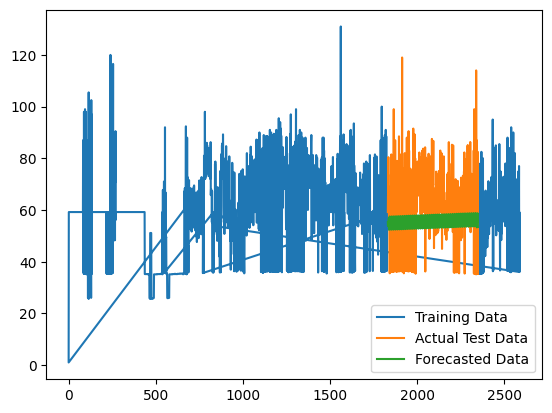

In [48]:
#SARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the data
# Update the file path as needed
data = pd.read_csv(file_path)

# Sort the data by 'Code', 'Name', and 'Time (WIB)'
data = data.sort_values(by=['Code', 'Name', 'Time (WIB)'])

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].mean(axis=1)
labels = data['Code']

# Handle missing values (replace NaN with mean for simplicity)
features = features.fillna(features.mean())

# Train-test split (80-20 split)
train_size = int(len(features) * 0.8)
train, test = features[:train_size], features[train_size:]

# Fit SARIMA model
order = (1, 1, 1)  # (p, d, q) parameters
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) parameters (adjust seasonality based on your data)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_model = model.fit()

# Forecast on test data
forecast = fit_model.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean

# Evaluate the model using mean squared error
mse = mean_squared_error(test, forecast_values)

print(f'Mean Squared Error: {mse}')

# Plotting
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast_values, label='Forecasted Data')
plt.legend()
plt.show()


/tmp/ipykernel_13036/4277985664.py:20: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  features = features.fillna(features.mean())
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xcf93vw/anr0_yd7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xcf93vw/o9uj2azh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/ihsannh17/miniconda3/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67605', 'data', 'file=/tmp/tmp1xcf93vw/anr0_yd7.json', 'init=/tmp/tmp1xcf93vw/o9uj2azh.json', 'output', 'file=/tmp/tmp1xcf93vw/prophet_modelp9oqq10w/prophet_model-20240117144123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start proc

Mean Squared Error: 201.2189913127413


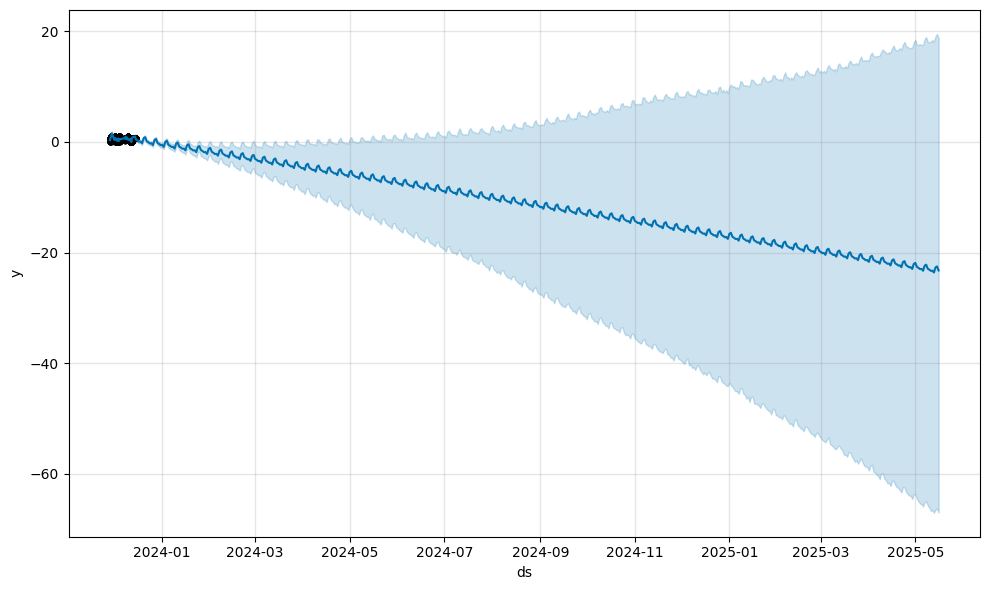

In [44]:
#Prophet
import pandas as pd
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
data = pd.read_csv(file_path)

# Sort the data by 'Code', 'Name', and 'Time (WIB)'
data = data.sort_values(by=['Code', 'Name', 'Time (WIB)'])

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].copy()
features['ds'] = pd.to_datetime(data['Time (WIB)'])
features['y'] = data['Code']

# Handle missing values (replace NaN with mean for simplicity)
features = features.fillna(features.mean())

# Train-test split (80-20 split)
train_size = int(len(features) * 0.8)
train, test = features[:train_size], features[train_size:]

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train)

# Create a dataframe for future dates
future = model.make_future_dataframe(periods=len(test))

# Predict on the future dates
forecast = model.predict(future)

# Extract actual values and predicted values
y_true = test['y'].values
y_pred = forecast['yhat'].values[-len(test):]

# Convert to discrete labels (0, 0.25, 0.5, 0.75, 1)
y_pred_discrete = np.round(y_pred / 0.25) * 0.25

# Evaluate the model using mean squared error
mse = mean_squared_error(y_true, y_pred_discrete)

print(f'Mean Squared Error: {mse}')

# Optionally, plot the forecast
fig = model.plot(forecast)


In [38]:
#GRU
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Load the data
# file_path = "~/x.csv"
data = pd.read_csv(file_path)

# Sort the data by 'Code', 'Name', and 'Time (WIB)'
data = data.sort_values(by=['Code', 'Name', 'Time (WIB)'])

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].values
labels = data['Code'].values

# Handle missing values (replace NaN with mean for simplicity)
features = np.nan_to_num(features, nan=np.nanmean(features))

# Normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Train-test split (80-20 split)
features_train, features_test, labels_train, labels_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Reshape the data for the GRU model
features_train = features_train.reshape(features_train.shape[0], 1, features_train.shape[1])
features_test = features_test.reshape(features_test.shape[0], 1, features_test.shape[1])

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, input_shape=(features_train.shape[1], features_train.shape[2])))
model.add(Dense(units=1, activation='linear'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(features_train, labels_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
predictions = model.predict(features_test)
predictions = np.round(predictions / 0.25) * 0.25  # Convert to discrete labels (0, 0.25, 0.5, 0.75, 1)

# Evaluate the model using accuracy or other appropriate metrics
accuracy = np.mean(predictions == labels_test)

print(f'Test Accuracy: {accuracy}')


Epoch 1/10
52/52 [==============================] - 3s 12ms/step - loss: 0.2190 - val_loss: 0.1309
Epoch 2/10
52/52 [==============================] - 0s 4ms/step - loss: 0.1398 - val_loss: 0.1273
Epoch 3/10
52/52 [==============================] - 0s 4ms/step - loss: 0.1362 - val_loss: 0.1272
Epoch 4/10
52/52 [==============================] - 0s 4ms/step - loss: 0.1342 - val_loss: 0.1259
Epoch 5/10
52/52 [==============================] - 0s 4ms/step - loss: 0.1331 - val_loss: 0.1257
Epoch 6/10
52/52 [==============================] - 0s 4ms/step - loss: 0.1325 - val_loss: 0.1255
Epoch 7/10
52/52 [==============================] - 0s 4ms/step - loss: 0.1320 - val_loss: 0.1236
Epoch 8/10
52/52 [==============================] - 0s 4ms/step - loss: 0.1306 - val_loss: 0.1244
Epoch 9/10
52/52 [==============================] - 0s 4ms/step - loss: 0.1312 - val_loss: 0.1226
Epoch 10/10
17/17 [==============================] - 0s 2ms/step
Test Accuracy: 0.14931947943530954


In [35]:
#ETS
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the data
file_path = "/home/ihsannh17/Downloads/RMP/github-repos/etc/2023-12-(04-14)_Label.csv"
data = pd.read_csv(file_path)

# Sort the data by 'Code', 'Name', and 'Time (WIB)'
data = data.sort_values(by=['Code', 'Name', 'Time (WIB)'])

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].values
labels = data['Code'].values

# Handle missing values (replace NaN with mean for simplicity)
features = np.nan_to_num(features, nan=np.nanmean(features))

# Train-test split (80-20 split)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# ETS model for training data
ets_train = ExponentialSmoothing(labels_train, seasonal='add', seasonal_periods=13)  # Adjust seasonal parameters based on your data
ets_fit = ets_train.fit()

# Forecast on training data
forecast_train = ets_fit.fittedvalues

# Evaluate the model on training data
mae_train = mean_absolute_error(labels_train, forecast_train)
mse_train = mean_squared_error(labels_train, forecast_train)

print(f'Training MAE: {mae_train}')
print(f'Training MSE: {mse_train}')

# Forecast on test data
ets_test = ExponentialSmoothing(labels_test, seasonal='add', seasonal_periods=13)
ets_fit_test = ets_test.fit()
forecast_test = ets_fit_test.fittedvalues

# Evaluate the model on test data
mae_test = mean_absolute_error(labels_test, forecast_test)
mse_test = mean_squared_error(labels_test, forecast_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')


Training MAE: 0.32649922858337743
Training MSE: 0.1409930830031985
Test MAE: 0.32968818913262476
Test MSE: 0.14395921728765435


In [33]:
#STL
import pandas as pd
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Load the data
file_path = "/home/ihsannh17/Downloads/RMP/github-repos/etc/2023-12-(04-14)_Label.csv"
data = pd.read_csv(file_path)

# Sort the data by 'Code', 'Name', and 'Time (WIB)'
data = data.sort_values(by=['Code', 'Name', 'Time (WIB)'])

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].values
labels = data['Code'].values

# Handle missing values (replace NaN with mean for simplicity)
features = np.nan_to_num(features, nan=np.nanmean(features))

# Train-test split (80-20 split)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# STL decomposition for training data
stl_train = STL(labels_train, seasonal=13)  # Adjust seasonal period based on your data
result_train = stl_train.fit()

# Forecast on training data
forecast_train = result_train.trend + result_train.seasonal + result_train.resid

# Convert forecast to discrete labels (0, 0.25, 0.5, 0.75, 1)
forecast_labels_train = np.round(forecast_train / 0.25) * 0.25

# Evaluate the model on training data
accuracy_train = accuracy_score(labels_train, forecast_labels_train)

print(f'Training Accuracy: {accuracy_train}')

# Forecast on test data
stl_test = STL(labels_test, seasonal=13)
result_test = stl_test.fit()
forecast_test = result_test.trend + result_test.seasonal + result_test.resid

# Convert forecast to discrete labels
forecast_labels_test = np.round(forecast_test / 0.25) * 0.25

# Evaluate the model on test data
accuracy_test = accuracy_score(labels_test, forecast_labels_test)

print(f'Test Accuracy: {accuracy_test}')

ValueError: Unable to determine period from endog

In [29]:
#ARIMA
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Load the data
file_path = "/home/ihsannh17/Downloads/RMP/github-repos/etc/2023-12-(04-14)_Label.csv"
data = pd.read_csv(file_path)

# Sort the data by time
data['Time (WIB)'] = pd.to_datetime(data['Time (WIB)'])
# data = data.sort_values(by='Time (WIB)')

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].values
labels = data['Code'].values

# Handle missing values (replace NaN with mean for simplicity)
features = np.nan_to_num(features, nan=np.nanmean(features))

# Train-test split (80-20 split)
train_size = int(len(features) * 0.8)
train_features, test_features = features[:train_size], features[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

# ARIMA model
order = (1, 1, 1)  # Example order, you may need to tune this based on your data
model = ARIMA(train_labels, exog=train_features, order=order)
fit_model = model.fit()

# Forecast
forecast = fit_model.forecast(steps=len(test_features), exog=test_features)

# Evaluate the model (you may need to choose an appropriate evaluation metric)
accuracy = np.mean(np.abs(test_labels - forecast) <= 0.25)

print(f'Model Accuracy: {accuracy}')


/home/ihsannh17/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ihsannh17/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ihsannh17/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Accuracy: 1.0


In [26]:
#Feedforward NN

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the data
file_path = "/home/ihsannh17/Downloads/RMP/github-repos/etc/2023-12-(04-14)_Label.csv"
data = pd.read_csv(file_path)

# Sort the data by time
data = data.sort_values(by='Time (WIB)')

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].values
labels = data['Code'].values

# Normalize features
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels_encoded, test_size=0.2, random_state=42)

# Define the feedforward neural network model
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy on Test Set: {accuracy}')


Epoch 1/10
52/52 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.2168 - val_loss: nan - val_accuracy: 0.2096
Epoch 2/10
52/52 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.2168 - val_loss: nan - val_accuracy: 0.2096
Epoch 3/10
52/52 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.2168 - val_loss: nan - val_accuracy: 0.2096
Epoch 4/10
52/52 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.2168 - val_loss: nan - val_accuracy: 0.2096
Epoch 5/10
52/52 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.2168 - val_loss: nan - val_accuracy: 0.2096
Epoch 6/10
52/52 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2168 - val_loss: nan - val_accuracy: 0.2096
Epoch 7/10
52/52 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.2168 - val_loss: nan - val_accuracy: 0.2096
Epoch 8/10
52/52 [==============================] - 0s 3ms/ste

In [25]:
#LSTM
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

# Load your sequential data
file_path = "/home/ihsannh17/Downloads/RMP/github-repos/etc/2023-12-(04-14)_Label.csv"
data = pd.read_csv(file_path)

# Sort the data by time in descending order
# data = data.sort_values(by='Time (WIB)', ascending=False)

# Extract features and labels
features = data[['SpO2', 'BP Dia', 'BP Sys', 'HRV', 'Stress', 'HR', 'Body Temp']].values
labels = data['Code'].values
# Normalize features
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
# Create sequences for LSTM without filling missing values
sequence_length = 10  # You can adjust this based on your preference
X_sequence, y_sequence = [], []

for i in range(len(features_normalized) - sequence_length + 1):
    seq = features_normalized[i:i + sequence_length]
    # Skip sequences with NaN values
    # if np.isnan(seq).any():
    #     continue
    X_sequence.append(seq)
    y_sequence.append(labels_encoded[i + sequence_length - 1])

X_sequence = np.array(X_sequence)
y_sequence = np.array(y_sequence)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequence, y_sequence, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Masking(mask_value=np.nan, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=64))
model.add(Dense(units=5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy on Test Set: {accuracy}')

# Make predictions on part of the training data
# You can adjust the index range based on your preference
start_index = 0
end_index = 50
new_features_sequence = X_train[start_index:end_index]

# Predict the labels for the selected sequence
predicted_probs = model.predict(new_features_sequence)
predicted_labels = np.argmax(predicted_probs, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_labels)
print('Predicted Labels:', predicted_labels)
"""
"""

Epoch 1/10
52/52 [==============================] - 6s 32ms/step - loss: nan - accuracy: 0.2035 - val_loss: nan - val_accuracy: 0.2107
Epoch 2/10
52/52 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.2035 - val_loss: nan - val_accuracy: 0.2107
Epoch 3/10
52/52 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.2035 - val_loss: nan - val_accuracy: 0.2107
Epoch 4/10
52/52 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.2035 - val_loss: nan - val_accuracy: 0.2107
Epoch 5/10
52/52 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.2035 - val_loss: nan - val_accuracy: 0.2107
Epoch 6/10
52/52 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2035 - val_loss: nan - val_accuracy: 0.2107
Epoch 7/10
52/52 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.2035 - val_loss: nan - val_accuracy: 0.2107
Epoch 8/10
52/52 [==============================] - 0s 8ms/st

'\n'

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load your dataset
# Replace this with your data loading process
file_label  = "/home/ihsannh17/Downloads/RMP/github-repos/etc/2023-12-(04-14)_Label.csv"
df = pd.read_csv(file_label)

# Preprocess your data
# Replace this with your data preprocessing steps
X = df.drop(['Code', 'Time (WIB)', 'Name', 'Device Code'], axis=1)  # Features
y = df['Code']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
AI for sequential data but with empty data is meaningful. Please give example code of this, maybe better in TF?
# Create a neural network model using TensorFlow's Keras API
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model2024-01-07 06:31:01.629942: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 06:31:01.899967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 06:31:01.900135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 06:31:01.955754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 06:31:02.053823: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 06:31:02.056310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")


2024-01-07 06:31:01.629942: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 06:31:01.899967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 06:31:01.900135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 06:31:01.955754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 06:31:02.053823: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 06:31:02.056310: I tensorflow/core/platform/cpu_feature_guard.cc:1

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

Epoch 1/10
25/25 [==============================] - 2s 23ms/step - loss: nan - accuracy: 0.3720 - val_loss: nan - val_accuracy: 0.3116
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2900 - val_loss: nan - val_accuracy: 0.3116
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2900 - val_loss: nan - val_accuracy: 0.3116
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2900 - val_loss: nan - val_accuracy: 0.3116
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2900 - val_loss: nan - val_accuracy: 0.3116
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2900 - val_loss: nan - val_accuracy: 0.3116
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2900 - val_loss: nan - val_accuracy: 0.3116
Epoch 8/10
25/25 [==============================] - 0s 7ms/st

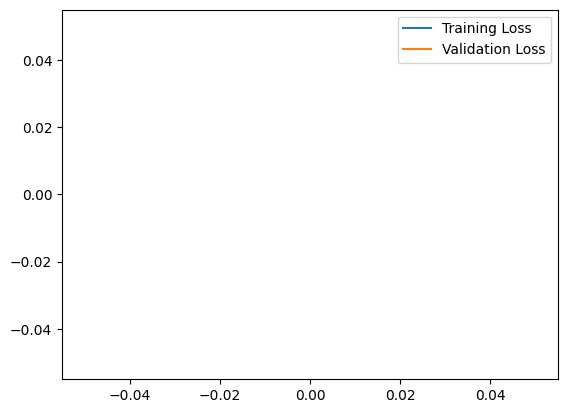

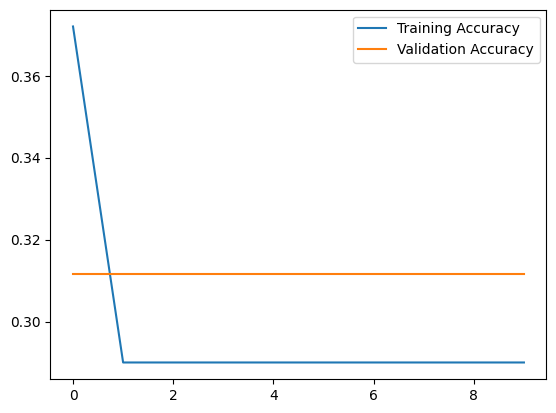

In [2]:
# Sequential: LSTM
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split


# Load the data from the CSV file
data_dir = "/home/ihsannh17/Downloads/RMP/github-repos/etc/training-ai/training_2.csv"
data = pd.read_csv(data_dir)

# Preprocess the data
# Convert timestamp to a numeric value (assuming it's in Unix timestamp format)
data['Timestamp'] = pd.to_datetime(data['Timestamp']).astype(np.int64)

# Splitting data into features (timestamp and biomarker) and labels
X = data[['Timestamp', 'Biomarker']].values
y = data['Label'].values

# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Define the sequence length
sequence_length = 10  # You can adjust this according to your data and sequence requirements

# Create sequences with corresponding labels
sequences = []
next_labels = []
for i in range(len(X_normalized) - sequence_length):
    sequences.append(X_normalized[i : i + sequence_length])
    next_labels.append(y[i + sequence_length - 1])

# Convert sequences and labels to numpy arrays
X_sequence = np.array(sequences)
y_sequence = np.array(next_labels)

# Reshape data for LSTM input (samples, timesteps, features)
X_sequence = X_sequence.reshape((X_sequence.shape[0], X_sequence.shape[1], X_sequence.shape[2]))
X_train, X_val, y_train, y_val = train_test_split(X_sequence, y_sequence, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_sequence.shape[1], X_sequence.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy}')

# Optionally, you can plot training and validation loss and accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [4]:
# Normal
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
data_dir = "/home/ihsannh17/Downloads/RMP/github-repos/etc/training-ai/training_2.csv"
data = pd.read_csv(data_dir)

# Preprocess the data
# Convert timestamp to a numeric value (assuming it's in Unix timestamp format)
data['Timestamp'] = pd.to_datetime(data['Timestamp']).astype(np.int64)

# Splitting data into features (timestamp and biomarker) and labels
X = data[['Timestamp', 'Biomarker']].values
y = data['Label'].values

# Normalize features (timestamp and biomarker)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Create a neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Make predictions on new data
# Replace new_data with the data you want to predict
new_data = np.array([[new_timestamp_1, new_biomarker_1], [new_timestamp_2, new_biomarker_2], ...])
scaled_new_data = scaler.transform(new_data)
predictions = model.predict(scaled_new_data)
print("Predictions:", predictions)


Epoch 1/10
23/23 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.4069 - val_loss: nan - val_accuracy: 0.3457
Epoch 2/10
23/23 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2972 - val_loss: nan - val_accuracy: 0.3457
Epoch 3/10
23/23 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.2972 - val_loss: nan - val_accuracy: 0.3457
Epoch 4/10
23/23 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2972 - val_loss: nan - val_accuracy: 0.3457
Epoch 5/10
23/23 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2972 - val_loss: nan - val_accuracy: 0.3457
Epoch 6/10
23/23 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2972 - val_loss: nan - val_accuracy: 0.3457
Epoch 7/10
23/23 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.2972 - val_loss: nan - val_accuracy: 0.3457
Epoch 8/10
23/23 [==============================] - 0s 3ms/ste

NameError: name 'new_timestamp_1' is not defined

In [2]:
# Training
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Print a portion of the dataset
print("Sample of the Iris dataset:")
for i in range(5):
    print(f"Features: {X[i]}, Target: {y[i]}")

# One-hot encode the target variable
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a sequential model
model = Sequential([
    Dense(10, activation='relu', input_shape=(X.shape[1],)),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy}")


Sample of the Iris dataset:
Features: [5.1 3.5 1.4 0.2], Target: 0
Features: [4.9 3.  1.4 0.2], Target: 0
Features: [4.7 3.2 1.3 0.2], Target: 0
Features: [4.6 3.1 1.5 0.2], Target: 0
Features: [5.  3.6 1.4 0.2], Target: 0


/home/ihsannh17/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1/1 [==============================] - 0s 174ms/step - loss: 0.1674 - accuracy: 0.9333

Test Accuracy: 0.9333333373069763
